In [1]:
!pip install -q git+https://github.com/sebastian-sz/resnet-rs-keras@main

In [2]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np
import matplotlib.pyplot as plt
import resnet_rs

print("Tensorflow version " + tf.__version__)

2022-01-10 16:53:42.450215: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-10 16:53:42.450324: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


# Detect my accelerator

In [3]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-01-10 16:53:46.927482: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-10 16:53:46.930292: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-10 16:53:46.930327: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-10 16:53:46.930353: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (98e242595075): /proc/driver/nvidia/version does not exist
2022-01-10 16:53:46.933437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

# Get my data path

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

# Set some parameters

In [5]:
DIM = 224
IMAGE_SIZE = [DIM, DIM] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 20
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
AUTO = tf.data.experimental.AUTOTUNE

# Load my data

This data is loaded from Kaggle and automatically sharded to maximize parallelization.

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + F'/tfrecords-jpeg-{DIM}x{DIM}/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + F'/tfrecords-jpeg-{DIM}x{DIM}/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + f'/tfrecords-jpeg-{DIM}x{DIM}/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

2022-01-10 16:53:53.922337: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-01-10 16:53:54.193295: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Learning Rate Scheduler

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


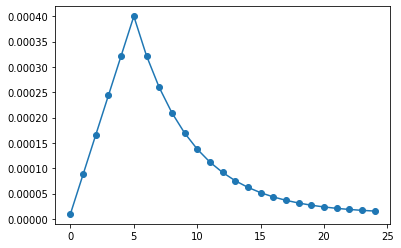

In [7]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Build a model

In [8]:
with strategy.scope():    
#     backbone = tf.keras.applications.VGG16(weights='imagenet', 
#                                            include_top=False ,
#                                            input_shape=[*IMAGE_SIZE, 3])
    backbone = resnet_rs.ResNetRS50(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    backbone.trainable = True # tramsfer learning
    
    model = tf.keras.Sequential([
        backbone,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

135364608/135360144 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet-rs-50 (Functional)    (None, 7, 7, 2048)        33696288  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 33,909,384
Trainable params: 33,856,008
Non-trainable params: 53,376
_________________________________________________________________


# Training

In [9]:
history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset,
          callbacks=[lr_callback])

Epoch 1/20
49/49 [==============================] - 77s 377ms/step - loss: 4.6301 - sparse_categorical_accuracy: 0.0152 - val_loss: 4.2201 - val_sparse_categorical_accuracy: 0.1223
Epoch 2/20
 1/49 [..............................] - ETA: 7s - loss: 4.1576 - sparse_categorical_accuracy: 0.1836

2022-01-10 16:55:28.639634: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 30551, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1641833728.636283765","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 30551, Output num: 1","grpc_status":3}


49/49 [==============================] - 8s 166ms/step - loss: 3.1353 - sparse_categorical_accuracy: 0.3643 - val_loss: 1.1710 - val_sparse_categorical_accuracy: 0.7317
Epoch 3/20
49/49 [==============================] - 8s 167ms/step - loss: 0.8630 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.5167 - val_sparse_categorical_accuracy: 0.8680
Epoch 4/20
49/49 [==============================] - 8s 166ms/step - loss: 0.2756 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.4187 - val_sparse_categorical_accuracy: 0.8912
Epoch 5/20
49/49 [==============================] - 8s 168ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.9755 - val_loss: 0.4292 - val_sparse_categorical_accuracy: 0.8925
Epoch 6/20
49/49 [==============================] - 8s 168ms/step - loss: 0.0896 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.4954 - val_sparse_categorical_accuracy: 0.8723
Epoch 7/20
49/49 [==============================] - 8s 166ms/step - loss: 0.0782 - sparse_categorical_accuracy:

# History

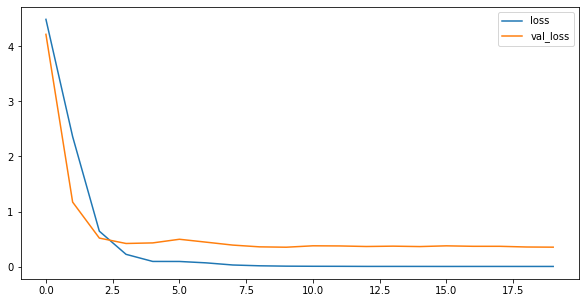

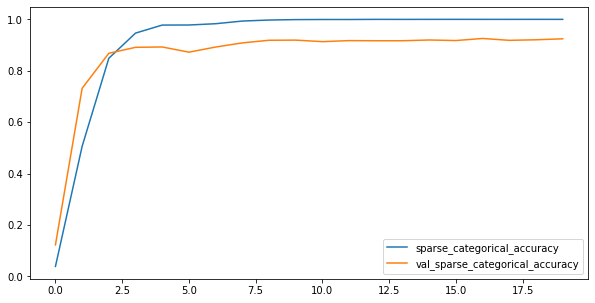

In [10]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 5)
data = pd.DataFrame(history.history)
metrics = ['loss', 'sparse_categorical_accuracy']
for metric in metrics:
    data[[f'{metric}',f'val_{metric}']].plot()

# Compute your predictions on the test set!

This will create a file that can be submitted to the competition.

In [11]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

2022-01-10 16:58:08.145051: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...


2022-01-10 16:58:25.004900: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 47243, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1641833905.004742936","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 47243, Output num: 0","grpc_status":3}


[ 67  28  83 ...  48 102  62]
Generating submission.csv file...
